# Document Classification

# Installing Libraries

In [1]:
! pip install transformers # transformer libraries from huggingface

     |████████████████████████████████| 3.4 MB 6.9 MB/s 
     |████████████████████████████████| 61 kB 561 kB/s 
     |████████████████████████████████| 596 kB 69.2 MB/s 
     |████████████████████████████████| 3.3 MB 52.4 MB/s 
     |████████████████████████████████| 895 kB 74.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Importing Libraries

In [2]:
import os
import datetime
import json
import ast
import random
import numpy as np
import pandas as pd
import torch
import seaborn
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, AdamW

# Initialize the random number generator.
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
tGenerator = torch.Generator()
tGenerator.manual_seed(42)
def seed_worker(worker_id):
  random.seed(42)
  np.random.seed(42)

# Define the available device.
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.device(device)

device(type='cuda')

# Downloading Datasets

In [3]:
# Download filtered_indosum.tar.gz.
os.system("gdown https://drive.google.com/uc?id=1RbsRMjXplaGTLMdk_vfa5b47gnZHg2y3")
# Extracting filtered_indosum.tar.gz.
! tar -xvf filtered_indosum.tar.gz
! rm filtered_indosum.tar.gz

filtered_indosum/
filtered_indosum/test.05.jsonl
filtered_indosum/test.02.jsonl
filtered_indosum/train.02.jsonl
filtered_indosum/train.04.jsonl
filtered_indosum/train.05.jsonl
filtered_indosum/test.03.jsonl
filtered_indosum/train.01.jsonl
filtered_indosum/dev.04.jsonl
filtered_indosum/test.01.jsonl
filtered_indosum/dev.05.jsonl
filtered_indosum/dev.01.jsonl
filtered_indosum/dev.02.jsonl
filtered_indosum/dev.03.jsonl
filtered_indosum/test.04.jsonl
filtered_indosum/train.03.jsonl


In [4]:
# Download summaries-bert2bert.tsv.
os.system('gdown https://drive.google.com/uc?id=1F5-3hl90ipuYYAxT64_GyrB6103Smr7-')

0

# Preprocessing Functions

In [17]:
def readSummary():
  """
  This function reads summaries from summaries-bert2bert.tsv file.
  returns articleDict (unique articles indexed by article ID).
  """

  articleDf = pd.read_csv("summaries-bert2bert.tsv", sep="\t")
  articleDict = {}
  for index, row in articleDf.iterrows():
    articleDict[row["id"]] = row["summary"]
  
  return articleDict

In [18]:
def loadDataset(type, k, strategy):
  """
  This function loads dataset.
  type: "train", "dev", or "test".
  k: 1, 2, 3, 4, 5.
  strategy: "take-all", "70first", "70middle", "70last", "35first-35middle", "35first-35last", "35middle-35last", "30first-20middle-20last", "summaryExt", "summaryAbs", "summaryAuto".
  returns articles, labels.
  """

  categoryIdDict = {"tajuk utama":0, "olahraga":1, "showbiz":2, "teknologi":3, "hiburan":4, "inspirasi":5}
  articles = []
  labels = []

  if strategy.startswith("summaryAuto"): # If the strategy is auto summarization, then read the data from summaries-bert2bert.tsv file.
    summaryDict = readSummary()

  with open(f"filtered_indosum/{type}.0{k}.jsonl") as lines: # Read "Filtered-IndoSum".
    for line in lines: # Loop over the lines.
      jsonObj = json.loads(line) # Convert json to be object.
      article = []

      # If the strategy is human-annotated abtractive summarization.
      if strategy.startswith("summaryAbs"):
        for sentence in jsonObj["summary"]: # Loop over sentences of abstractive summary.
          article.extend(sentence) # Then pool the sentences in an article.

      # If the strategy is human-annotated extractive summarization.
      elif strategy.startswith("summaryExt"):
        for paragraph, isSummarys in zip(jsonObj["paragraphs"], jsonObj["gold_labels"]): # Loop over paragraph.
          for sentence, isSummary in zip(paragraph, isSummarys): # Loop over Sentence.
            if isSummary == True or isSummary == "True" or isSummary == 1: # If it is a label of extractive summary.
              article.extend(sentence) # Then pool the sentences in an article.

      # If the strategy is auto summarization.
      elif strategy.startswith("summaryAuto"):
        article = summaryDict[jsonObj["id"]] # Then set the article variable with the value of summary.

      # If the strategy is truncation.
      else:
        # BEGIN: Pooling the sentences in an article variable.
        for paragraph in jsonObj["paragraphs"]: # Loop over paragraph.
          for sentence in paragraph: # Loop over Sentence.
            article.extend(sentence) # Pool the sentence.
        # END: Pooling the sentences in an article variable.

        # Then, truncate the article.
        if strategy == "70first":
          article = article[0:70]
        elif strategy == "70middle":
          length = len(article)
          start = int(length/2) - int(70/2)
          article = article[start:start+70]
        elif strategy == "70last":
          length = len(article)
          article = article[length-70:length]
        elif strategy == "35first-35middle":
          length = len(article)
          start = int(length/2) - int(35/2)
          firstPart = article[0:35]
          middlePart = article[start:start+35]
          article = firstPart + middlePart
        elif strategy == "35first-35last":
          length = len(article)
          firstPart = article[0:35]
          lastPart = article[length-35:length]
          article = firstPart + lastPart
        elif strategy == "35middle-35last":
          length = len(article)
          start = int(length/2) - int(35/2)
          middlePart = article[start:start+35]
          lastPart = article[length-35:length]
          article = middlePart + lastPart
        elif strategy == "30first-20middle-20last":
          length = len(article)
          start = int(length/2) - int(20/2)
          firstPart = article[0:30]
          middlePart = article[start:start+20]
          lastPart = article[length-20:length]
          article = firstPart + middlePart + lastPart
          
      articles.append(article) # Pool the articles in an array.
      labels.append(categoryIdDict[jsonObj["category"]]) # Pool the classification labels in an array.

  return articles, labels

In [19]:
def preprocess(k, tokenizer, strategy="take-all"):
  """
  This function does preprocessing.
  k: 1, 2, 3, 4, 5.
  strategy: "take-all", "70first", "70middle", "70last", "35first-35middle", "35first-35last", "35middle-35last", "30first-20middle-20last", "summaryExt", "summaryAbs", "summaryAuto".
  returns datasetTrain, datasetVal, datasetTest.
  """
  print(f"Fold{k} Preprocessing...")

  # BEGIN: Loading dataset.
  articlesTrain, labelsTrain = loadDataset("train", k, strategy)
  articlesVal, labelsVal = loadDataset("dev", k, strategy)
  articlesTest, labelsTest = loadDataset("test", k, strategy)
  # END: Loading dataset.

  # BEGIN: Encoding the data.
  if strategy.startswith("summaryAuto"):
    isSplitIntoWords = False
  else:
    isSplitIntoWords = True

  if strategy == "take-all":
    encodedDataTrain = tokenizer(articlesTrain, is_split_into_words=isSplitIntoWords, padding=True, max_length=512, truncation=True)
    encodedDataVal = tokenizer(articlesVal, is_split_into_words=isSplitIntoWords, padding=True, max_length=512, truncation=True)
    encodedDataTest = tokenizer(articlesTest, is_split_into_words=isSplitIntoWords, padding=True, max_length=512, truncation=True)
  else:
    encodedDataTrain = tokenizer(articlesTrain, is_split_into_words=isSplitIntoWords, padding=True)
    encodedDataVal = tokenizer(articlesVal, is_split_into_words=isSplitIntoWords, padding=True)
    encodedDataTest = tokenizer(articlesTest, is_split_into_words=isSplitIntoWords, padding=True)
  # END: Encoding the data.

  # BEGIN: Converting data to be torch tensor format.
  tensorsTrain = [torch.tensor(encodedDataTrain["input_ids"], dtype=torch.long), 
                torch.tensor(encodedDataTrain["attention_mask"], dtype=torch.long), 
                torch.tensor(labelsTrain, dtype=torch.long)]
  tensorsVal = [torch.tensor(encodedDataVal["input_ids"], dtype=torch.long), 
                  torch.tensor(encodedDataVal["attention_mask"], dtype=torch.long), 
                  torch.tensor(labelsVal, dtype=torch.long)]
  tensorsTest = [torch.tensor(encodedDataTest["input_ids"], dtype=torch.long), 
                  torch.tensor(encodedDataTest["attention_mask"], dtype=torch.long), 
                  torch.tensor(labelsTest, dtype=torch.long)]
  # END: Converting data to be torch tensor format.
  
  # BEGIN: Wrapping as TensorDataset.
  datasetTrain = TensorDataset(*tensorsTrain)
  datasetVal = TensorDataset(*tensorsVal)
  datasetTest = TensorDataset(*tensorsTest)
  # END: Wrapping as TensorDataset.

  print(f"Fold{k} Preprocessing Finished!")
  return datasetTrain, datasetVal, datasetTest

# Fine-Tuning Functions

In [20]:
def drawHistory(trainLosses, valLosses, valAccuracies, valF1Scores):
  """
  This function draws training history as line graphs.
  """
  plt.figure(figsize=(20,5))
  
  plt.subplot(1, 4, 1)
  plt.plot(trainLosses, label="train loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training Loss")
  plt.legend()
  plt.xticks(np.arange(0, 5))

  plt.subplot(1, 4, 2)
  plt.plot(valLosses, label="val loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Validation Loss")
  plt.legend()
  plt.xticks(np.arange(0, 5))

  plt.subplot(1, 4, 3)
  plt.plot(valAccuracies, label="val acc")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title("Validation Accuracy")
  plt.legend()
  plt.xticks(np.arange(0, 5))

  plt.subplot(1, 4, 4)
  plt.plot(valF1Scores, label="val f1")
  plt.xlabel("Epoch")
  plt.ylabel("F1-Score")
  plt.title("Validation F1-Score")
  plt.legend()
  plt.xticks(np.arange(0, 5))

  plt.show()

In [21]:
def train(model, trainDataLoader, optimizer):
  """
  This function trains a model using training data.
  returns loss info.
  """
  model.train() # Set the model as training mode.

  trainLoss = 0 # Cumulative loss.

  for batch in trainDataLoader: # Loop over batches.
    model.zero_grad() # Re-init new gradient for every loop.

    # Unpacking data, moving to GPU if available.
    inputIds = batch[0].to(device)
    attentionMasks = batch[1].to(device)
    labels = batch[2].to(device)

    outputs = model(inputIds, attention_mask=attentionMasks, labels=labels) # Feed forward.
    loss = outputs.loss # By default it uses Categorical Cross Entropy as loss function.
    trainLoss += loss.item() # Getting loss info.
    
    loss.backward() # Back-propagation. Computing gradient.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # OPTIONAL. Gradient clipping to avoid exploding gradient.
    optimizer.step() # Updating parameters.

  model.eval() # IMPORTANT! Set the model as evaluation mode.
  return trainLoss / len(trainDataLoader) # Need to average, because it is batch processing.

In [22]:
def validate(model, valDataLoader):
  """
  This function evaluates a model using evaluation data.
  returns loss, accuracy, and f1-score info.
  """
  model.eval() # IMPORTANT! Set the model as evaluation mode.

  predictions = []
  targets = []
  loss = 0 # Cumulative loss.

  for batch in valDataLoader: # Loop over batches.
    # Unpacking data, moving to GPU if available.
    inputIds = batch[0].to(device)
    attentionMasks = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad(): # IMPORTANT! Do not compute gradient!
      outputs = model(inputIds, attention_mask=attentionMasks, labels=labels) # Feed forward.
    
    loss += outputs.loss.item() # Getting loss info.
    logits = outputs.logits.detach().cpu() # Getting logits, moving to CPU.

    preds = torch.argmax(logits, dim=1).numpy() # Getting most probable prediction. No need to softmax.
    labels = labels.detach().cpu().numpy() # Moving to CPU.

    predictions.extend(preds)
    targets.extend(labels)

  # Calculate Evaluation Loss.
  loss = loss / len(valDataLoader) # Need to average, because it is batch processing.

  # Calculate Evaluation Accuracy.
  accuracy = accuracy_score(targets, predictions)

  # Calculate Evaluation F1-Score.
  f1Score = f1_score(targets, predictions, average="macro")

  return loss, accuracy, f1Score

In [23]:
def fineTune(k, model, datasetTrain, datasetVal):
  """
  This function fine-tunes a model.
  k: 1, 2, 3, 4, or 5.
  """
  startTime = datetime.datetime.now()
  print(f"Fold{k} Fine-Tuning...")
  print("Started at", startTime.strftime("%Y-%m-%d %H:%M:%S"))

  # Hyperparameters
  learningRate = 2e-5
  batchSize = 16
  valBatchSize = 1
  epochs = 5
  weightDecay = 0 # AdamW default
  epsilon = 1e-8 # default

  # AdamW is the most used optimizer.
  optimizer = AdamW(model.parameters(), lr=learningRate, eps=epsilon, weight_decay=weightDecay)

  # Use DataLoader for batch processing.
  trainDataLoader = DataLoader(datasetTrain, batch_size=batchSize, worker_init_fn=seed_worker, num_workers=0, generator=tGenerator)
  valDataLoader = DataLoader(datasetVal, batch_size=valBatchSize, worker_init_fn=seed_worker, num_workers=0, generator=tGenerator)

  trainLosses = [] # To pool training loss values.
  valLosses = [] # To pool validation loss values.
  valAccuracies = [] # To pool validation accuracy values.
  valF1Scores = [] # To pool validation f1-score values.

  bestScore = 0
  for epoch in range(1, epochs+1): # Loop epochs.
    # Training the model.
    trainLoss = train(model, trainDataLoader, optimizer)
    trainLosses.append(trainLoss)

    # Evaluating the model.
    valLoss, valAccuracy, valF1Score = validate(model, valDataLoader)
    valLosses.append(valLoss)
    valAccuracies.append(valAccuracy)
    valF1Scores.append(valF1Score)

    if valF1Score > bestScore:
      bestScore = valF1Score
      print(f"BEST SCORE: {bestScore}")
      model.save_pretrained("my_best_model") # Save the best model. It produces two files: config.json & pytorch_model.bin.

    print(f"Epoch: {epoch} | loss: {trainLoss} | valLoss: {valLoss} | valAcc: {valAccuracy} | valF1: {valF1Score}")

  # Once finished, draw training & evaluation history.
  drawHistory(trainLosses, valLosses, valAccuracies, valF1Scores)

  endTime = datetime.datetime.now()
  print("Finished at", endTime.strftime("%Y-%m-%d %H:%M:%S"))
  print("Executed in", endTime-startTime)
  print(f"Fold{k} Fine-Tuning Finished!")

# Testing Functions

In [24]:
def testing(k, model, datasetTest):
  """
  This function evaluate a model using testing data.
  k: 1, 2, 3, 4, or 5.
  returns accuracy and f1-score info.
  """
  print(f"Fold{k} Testing...")
  model.eval() # IMPORTANT! Set the model as evaluation mode.

  predictions = []
  targets = []

  # Use DataLoader for batch processing.
  testDataLoader = DataLoader(datasetTest, batch_size=16, worker_init_fn=seed_worker, num_workers=0, generator=tGenerator)

  for batch in testDataLoader: # Loop over batches.
    # Unpacking data, moving to GPU if available.
    inputIds = batch[0].to(device)
    attentionMasks = batch[1].to(device)
    labels = batch[2].numpy() # CPU only

    with torch.no_grad(): # IMPORTANT! Do not compute gradient!
      outputs = model(inputIds, attention_mask=attentionMasks) # Feed forward. Without calculating loss.
    
    logits = outputs.logits.detach().cpu() # Getting logits, moving to CPU.
    preds = torch.argmax(logits, dim=1).numpy() # Getting most probable prediction. No need to softmax.

    predictions.extend(preds)
    targets.extend(labels)

  # Calculate Evaluation Accuracy.
  accuracy = accuracy_score(targets, predictions)

  # Calculate Evaluation F1-Score.
  f1Score = f1_score(targets, predictions, average="macro")

  # Print reporting.
  report = classification_report(targets, predictions)
  print(report)

  print(f"Fold{k} | testAcc: {accuracy} | testF1: {f1Score}")
  print(f"Fold{k} Testing Finished!")
  return accuracy, f1Score

# Running K-Fold Cross Validation

Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/473 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/260M [00:00<?, ?B/s]

Some weights of the model checkpoint at cahya/distilbert-base-indonesian were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['classifier.weight', 'classifier.bias

Fold1 Preprocessing...
Fold1 Preprocessing Finished!
Fold1 Fine-Tuning...
Started at 2022-01-08 14:14:38
BEST SCORE: 0.7695225863541825
Epoch: 1 | loss: 0.3090358581421675 | valLoss: 0.2205722666351147 | valAcc: 0.9397590361445783 | valF1: 0.7695225863541825
BEST SCORE: 0.7732115842376062
Epoch: 2 | loss: 0.18987558988599285 | valLoss: 0.24631724910072825 | valAcc: 0.9412650602409639 | valF1: 0.7732115842376062
BEST SCORE: 0.8576804012451973
Epoch: 3 | loss: 0.14182297370834498 | valLoss: 0.26500516294732096 | valAcc: 0.9457831325301205 | valF1: 0.8576804012451973
Epoch: 4 | loss: 0.1045092360751975 | valLoss: 0.30806825596397197 | valAcc: 0.9397590361445783 | valF1: 0.8528983686890909
Epoch: 5 | loss: 0.07803443109237594 | valLoss: 0.3627778030427016 | valAcc: 0.9382530120481928 | valF1: 0.8485631316352232


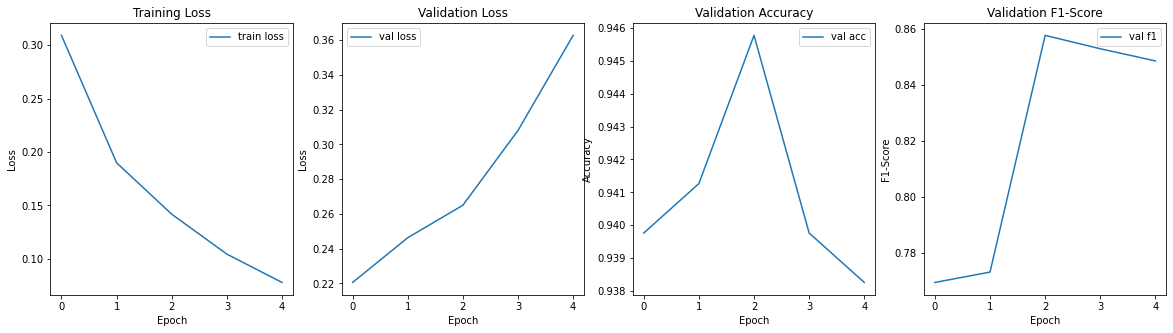

Finished at 2022-01-08 14:40:10
Executed in 0:25:31.709013
Fold1 Fine-Tuning Finished!
Fold1 Testing...
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       794
           1       0.99      1.00      0.99       511
           2       0.94      0.91      0.92       294
           3       0.92      0.95      0.94       240
           4       0.75      0.77      0.76       183
           5       0.00      0.00      0.00        15

    accuracy                           0.93      2037
   macro avg       0.76      0.76      0.76      2037
weighted avg       0.93      0.93      0.93      2037

Fold1 | testAcc: 0.9302896416298478 | testF1: 0.7586748356744996
Fold1 Testing Finished!


Some weights of the model checkpoint at cahya/distilbert-base-indonesian were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['classifier.weight', 'classifier.bias

Fold2 Preprocessing...
Fold2 Preprocessing Finished!
Fold2 Fine-Tuning...
Started at 2022-01-08 14:40:57
BEST SCORE: 0.7577293750296462
Epoch: 1 | loss: 0.30211435741789283 | valLoss: 0.24125571714308208 | valAcc: 0.9321266968325792 | valF1: 0.7577293750296462
BEST SCORE: 0.7640527134417119
Epoch: 2 | loss: 0.18403922835603312 | valLoss: 0.2716133004517279 | valAcc: 0.9351432880844646 | valF1: 0.7640527134417119
Epoch: 3 | loss: 0.13504275736254168 | valLoss: 0.3068848389446164 | valAcc: 0.9321266968325792 | valF1: 0.7578111688720627
Epoch: 4 | loss: 0.09788935869038964 | valLoss: 0.34751369838888524 | valAcc: 0.9306184012066365 | valF1: 0.7559809053568302
Epoch: 5 | loss: 0.06770293458603624 | valLoss: 0.4500851373249741 | valAcc: 0.9260935143288085 | valF1: 0.751825396139466


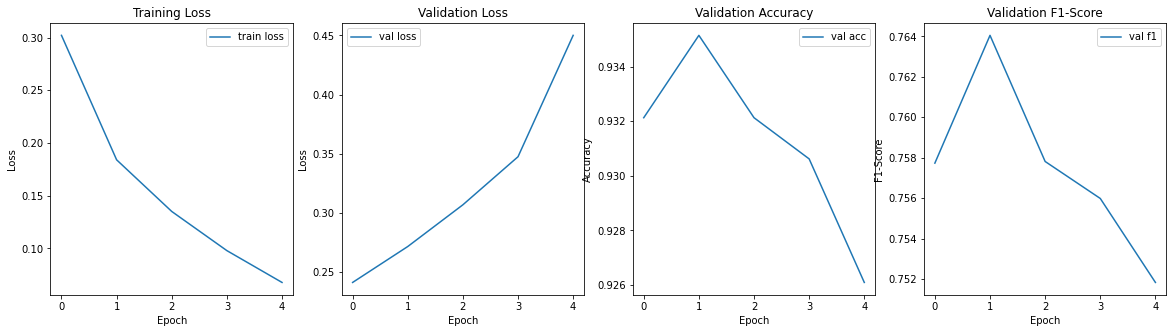

Finished at 2022-01-08 15:06:28
Executed in 0:25:31.606715
Fold2 Fine-Tuning Finished!
Fold2 Testing...
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       794
           1       0.98      1.00      0.99       511
           2       0.88      0.95      0.91       294
           3       0.95      0.93      0.94       240
           4       0.76      0.76      0.76       181
           5       0.50      0.08      0.13        13

    accuracy                           0.94      2033
   macro avg       0.84      0.78      0.78      2033
weighted avg       0.93      0.94      0.93      2033

Fold2 | testAcc: 0.9350713231677324 | testF1: 0.7807587325146385
Fold2 Testing Finished!


Some weights of the model checkpoint at cahya/distilbert-base-indonesian were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['classifier.weight', 'classifier.bias

Fold3 Preprocessing...
Fold3 Preprocessing Finished!
Fold3 Fine-Tuning...
Started at 2022-01-08 15:07:16
BEST SCORE: 0.7845755658682582
Epoch: 1 | loss: 0.3158806698275024 | valLoss: 0.1642646289655288 | valAcc: 0.9561270801815431 | valF1: 0.7845755658682582
BEST SCORE: 0.8946636404458936
Epoch: 2 | loss: 0.19659573937292982 | valLoss: 0.1790718302682307 | valAcc: 0.9561270801815431 | valF1: 0.8946636404458936
Epoch: 3 | loss: 0.14258768000445546 | valLoss: 0.18977986987824264 | valAcc: 0.9515885022692889 | valF1: 0.8607856088114342
Epoch: 4 | loss: 0.09955699897176111 | valLoss: 0.259240469056928 | valAcc: 0.9455370650529501 | valF1: 0.7673589954701968
Epoch: 5 | loss: 0.07165198562309398 | valLoss: 0.2928405047781403 | valAcc: 0.9440242057488654 | valF1: 0.7701474687808864


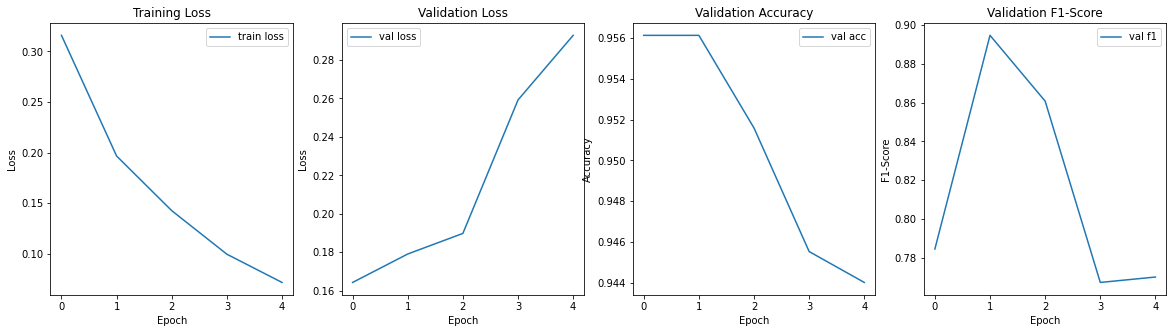

Finished at 2022-01-08 15:32:48
Executed in 0:25:32.708544
Fold3 Fine-Tuning Finished!
Fold3 Testing...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.97      0.93      0.95       792
           1       0.98      0.99      0.99       511
           2       0.87      0.99      0.92       294
           3       0.96      0.93      0.94       239
           4       0.78      0.80      0.79       181
           5       0.00      0.00      0.00        13

    accuracy                           0.94      2030
   macro avg       0.76      0.77      0.76      2030
weighted avg       0.93      0.94      0.93      2030

Fold3 | testAcc: 0.9354679802955665 | testF1: 0.764891736953842
Fold3 Testing Finished!


Some weights of the model checkpoint at cahya/distilbert-base-indonesian were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['classifier.weight', 'classifier.bias

Fold4 Preprocessing...
Fold4 Preprocessing Finished!
Fold4 Fine-Tuning...
Started at 2022-01-08 15:33:35
BEST SCORE: 0.7443029034428742
Epoch: 1 | loss: 0.30005119878931574 | valLoss: 0.24409077426834935 | valAcc: 0.9272727272727272 | valF1: 0.7443029034428742
BEST SCORE: 0.8190450166314257
Epoch: 2 | loss: 0.19099487962871015 | valLoss: 0.2711438345176055 | valAcc: 0.9303030303030303 | valF1: 0.8190450166314257
Epoch: 3 | loss: 0.14081591620860015 | valLoss: 0.3319550600575784 | valAcc: 0.9181818181818182 | valF1: 0.8124506156843454
BEST SCORE: 0.8281931820450597
Epoch: 4 | loss: 0.1033018802309597 | valLoss: 0.35915304100005113 | valAcc: 0.9272727272727272 | valF1: 0.8281931820450597
Epoch: 5 | loss: 0.07567041796403086 | valLoss: 0.41088209340351484 | valAcc: 0.9166666666666666 | valF1: 0.8104624805072412


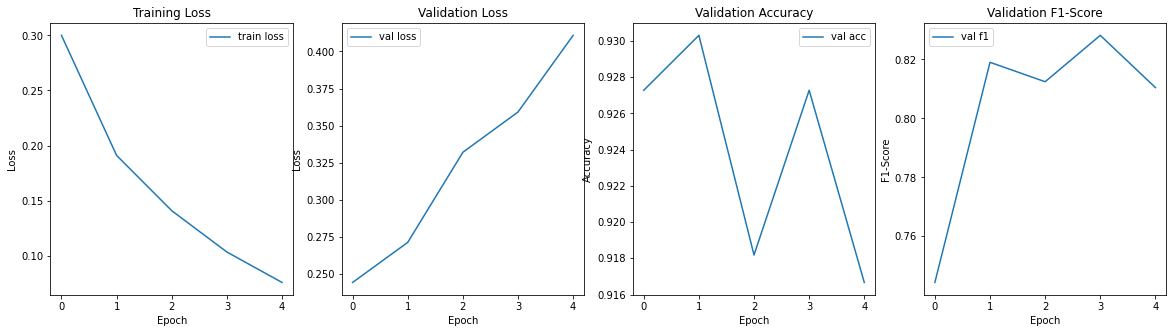

Finished at 2022-01-08 15:59:10
Executed in 0:25:34.623442
Fold4 Fine-Tuning Finished!
Fold4 Testing...
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       790
           1       0.99      0.96      0.98       511
           2       0.89      0.95      0.92       292
           3       0.94      0.92      0.93       238
           4       0.84      0.64      0.72       179
           5       0.25      0.23      0.24        13

    accuracy                           0.92      2023
   macro avg       0.80      0.78      0.79      2023
weighted avg       0.92      0.92      0.92      2023

Fold4 | testAcc: 0.9199209095402867 | testF1: 0.7868017401539111
Fold4 Testing Finished!


Some weights of the model checkpoint at cahya/distilbert-base-indonesian were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['classifier.weight', 'classifier.bias

Fold5 Preprocessing...
Fold5 Preprocessing Finished!
Fold5 Fine-Tuning...
Started at 2022-01-08 15:59:56
BEST SCORE: 0.7705131541053115
Epoch: 1 | loss: 0.3075455888133021 | valLoss: 0.22442288536394975 | valAcc: 0.9409090909090909 | valF1: 0.7705131541053115
BEST SCORE: 0.7740441700103667
Epoch: 2 | loss: 0.19244694372587934 | valLoss: 0.23345129582096089 | valAcc: 0.9454545454545454 | valF1: 0.7740441700103667
Epoch: 3 | loss: 0.14370708103403615 | valLoss: 0.28475525471078456 | valAcc: 0.9318181818181818 | valF1: 0.759211071409528
BEST SCORE: 0.7751946558513604
Epoch: 4 | loss: 0.10131629807211304 | valLoss: 0.28667118478333575 | valAcc: 0.9454545454545454 | valF1: 0.7751946558513604
Epoch: 5 | loss: 0.07003944058091109 | valLoss: 0.3456750403146461 | valAcc: 0.9378787878787879 | valF1: 0.769052585849758


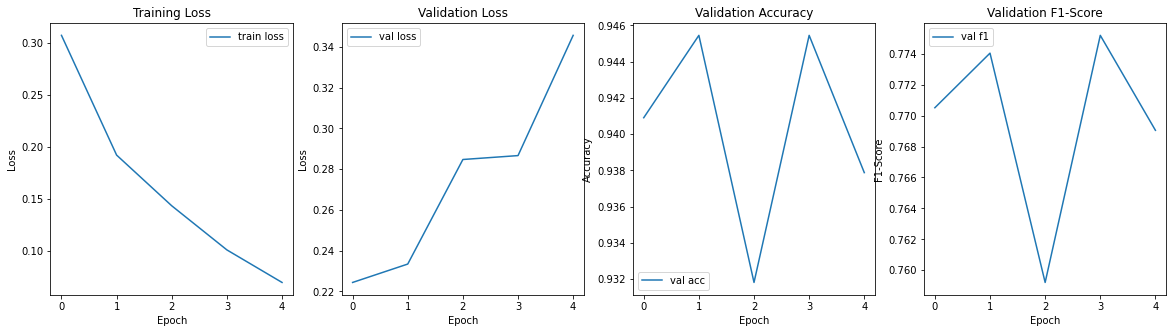

Finished at 2022-01-08 16:25:32
Executed in 0:25:35.761562
Fold5 Fine-Tuning Finished!
Fold5 Testing...
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       790
           1       0.97      0.99      0.98       510
           2       0.89      0.94      0.91       290
           3       0.93      0.96      0.95       237
           4       0.81      0.68      0.74       178
           5       0.27      0.33      0.30        12

    accuracy                           0.93      2017
   macro avg       0.80      0.81      0.80      2017
weighted avg       0.93      0.93      0.93      2017

Fold5 | testAcc: 0.9300941993058999 | testF1: 0.8041609932969248
Fold5 Testing Finished!
Accuracy: 0.9301688107878668
F1-Score: 0.7790576077187632


In [25]:
"""
Choose your strategy.
"""
# take-all, 70first, 70middle, 70last, 
# 35first-35middle, 35first-35last, 35middle-35last, 30first-20middle-20last,
# summaryExt, summaryAbs, summaryAuto.
strategy = "take-all" # Replace with the preferred one.

"""
Define which fold(s) to run.
"""
startFold = 1
folds = 5

"""
Loading Tokenizer.
"""
tokenizer = DistilBertTokenizerFast.from_pretrained("cahya/distilbert-base-indonesian")
print("==================================================")

"""
Running the main part.
"""
accuracies = []
f1Scores = []

for k in range(startFold, startFold+folds): # Loop over k.
  # Loading Fresh Pretrained Model (for every new k).
  model = DistilBertForSequenceClassification.from_pretrained("cahya/distilbert-base-indonesian", num_labels=6)
  model.to(device) # Moving into GPU if available.
  print("==================================================")
  
  # Preprocessing.
  datasetTrain, datasetVal, datasetTest = preprocess(k, tokenizer, strategy)
  
  # Fine-Tuning the Model.
  fineTune(k, model, datasetTrain, datasetVal)

  # Loading the Best (Saved) Model.
  model = DistilBertForSequenceClassification.from_pretrained("my_best_model")
  model.to(device) # Send to GPU if available.

  # Testing the Best Model
  accuracy, f1Score = testing(k, model, datasetTest)
  accuracies.append(accuracy)
  f1Scores.append(f1Score)

  print("==================================================")

print(f"Accuracy: {np.average(accuracies)}")
print(f"F1-Score: {np.average(f1Scores)}")